In [1]:
!pip install --quiet minio pyarrow pandas matplotlib seaborn
print("Dependencies installation completed.")

Dependencies installation completed.


In [2]:
from minio import Minio
from minio.error import S3Error
import pandas as pd
import io

# Connect to MinIO (Docker service name)
client = Minio(
    "minio:9002",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False
)

# Test connection
print("Connecting to MinIO...")
buckets = client.list_buckets()
print("Connection successful. Available buckets:")
for bucket in buckets:
    print(f"  - {bucket.name}")


Connecting to MinIO...
Connection successful. Available buckets:
  - bronze
  - gold
  - silver


In [3]:
silver_bucket = "silver"

print(f"\nParquet files in '{silver_bucket}' bucket:")
parquet_files = []

objects = client.list_objects(silver_bucket, recursive=True)
for obj in objects:
    if obj.object_name.endswith('.parquet'):
        print(f"  Found: {obj.object_name} ({obj.size:,} bytes)")
        parquet_files.append(obj.object_name)

print(f"\nTotal: {len(parquet_files)} Parquet files")



Parquet files in 'silver' bucket:
  Found: merged_data.parquet (141,932 bytes)
  Found: traffic_clean.parquet (24,854 bytes)
  Found: weather_clean.parquet (203,552 bytes)

Total: 3 Parquet files


In [4]:
silver_bucket = "gold"

print(f"\nParquet files in '{silver_bucket}' bucket:")
parquet_files = []

objects = client.list_objects(silver_bucket, recursive=True)
for obj in objects:
    if obj.object_name.endswith('.parquet'):
        print(f"  Found: {obj.object_name} ({obj.size:,} bytes)")
        parquet_files.append(obj.object_name)

print(f"\nTotal: {len(parquet_files)} Parquet files")



Parquet files in 'gold' bucket:
  Found: monte_carlo_results.parquet (2,134 bytes)
  Found: traffic_weather_factors.parquet (463,997 bytes)

Total: 2 Parquet files


In [5]:
# Step 1: Discover Gold bucket files (RUN THIS FIRST)
gold_bucket = "gold"
gold_files = []

print(f"Discovering files in '{gold_bucket}' bucket...")
objects = client.list_objects(gold_bucket, recursive=True)
for obj in objects:
    if obj.object_name.endswith('.parquet'):
        print(f"  Found: {obj.object_name} ({obj.size:,} bytes)")
        gold_files.append(obj.object_name)

print(f"\nTotal Gold files discovered: {len(gold_files)}")


Discovering files in 'gold' bucket...
  Found: monte_carlo_results.parquet (2,134 bytes)
  Found: traffic_weather_factors.parquet (463,997 bytes)

Total Gold files discovered: 2


In [6]:
# Step 2: Load Gold files (NOW gold_files exists)
gold_dataframes = {}

for file_name in gold_files:  # Now this works!
    print(f"\nLoading {file_name}...")
    try:
        response = client.get_object(gold_bucket, file_name)
        df = pd.read_parquet(io.BytesIO(response.read()))
        response.close()
        gold_dataframes[file_name] = df
        print(f"✓ {file_name}: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(df.head(3))
    except Exception as e:
        print(f"✗ Error: {e}")

print(f"\n Loaded {len(gold_dataframes)} Gold datasets")



Loading monte_carlo_results.parquet...
✓ monte_carlo_results.parquet: 11 rows × 4 columns
               mean_estimate  std_estimate  min_estimate  max_estimate
index                                                                 
traffic_id        11392.4744       16.1688    11333.7753    11465.0258
vehicle_count      2625.8936       17.9810     2566.4201     2689.7818
avg_speed_kmh        58.9057        0.3845       57.4247       60.5591

Loading traffic_weather_factors.parquet...
✓ traffic_weather_factors.parquet: 8,020 rows × 24 columns
   traffic_id date_time_traffic    city     area  vehicle_count  \
0      9001.0        2024-01-01  London  Chelsea         2425.0   
1      9001.0        2024-01-01  London  Chelsea         2425.0   
2      9001.0        2024-01-01  London  Chelsea         2425.0   

   avg_speed_kmh  accident_count congestion_level road_condition  \
0       5.330232             4.0             High          Snowy   
1       5.330232             4.0             H

In [7]:

# Direct access to your Gold datasets
monte_carlo_df = gold_dataframes["monte_carlo_results.parquet"]
traffic_factors_df = gold_dataframes["traffic_weather_factors.parquet"]

print("MONTE CARLO RESULTS:")
print(f"Shape: {monte_carlo_df.shape}")
monte_carlo_df.head()

MONTE CARLO RESULTS:
Shape: (11, 4)


,mean_estimate,std_estimate,min_estimate,max_estimate
index,,,,
traffic_id,11392.4744,16.1688,11333.7753,11465.0258
vehicle_count,2625.8936,17.9810,2566.4201,2689.7818
avg_speed_kmh,58.9057,0.3845,57.4247,60.5591
accident_count,5.5181,0.0386,5.3595,5.6693
visibility_m_traffic,5398.4468,36.0122,5261.4547,5532.1282


In [8]:
print("TRAFFIC WEATHER FACTORS:")
print(f"Shape: {traffic_factors_df.shape}")
traffic_factors_df.head()


TRAFFIC WEATHER FACTORS:
Shape: (8020, 24)


,traffic_id,date_time_traffic,city,area,vehicle_count,avg_speed_kmh,accident_count,congestion_level,road_condition,visibility_m_traffic,...,humidity,rain_mm,wind_speed_kmh,visibility_m_weather,weather_condition,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,9001.0,2024-01-01,London,Chelsea,2425.0,5.330232,4.0,High,Snowy,5801.0,...,31.0,38.697895,32.548405,9759.0,Storm,0.145764,1.571209,0.186390,2.304678,-0.079974
1,9001.0,2024-01-01,London,Chelsea,2425.0,5.330232,4.0,High,Snowy,5801.0,...,73.0,27.555337,73.351849,6973.0,Rain,0.148933,0.603822,0.178926,2.276203,-0.085886
2,9001.0,2024-01-01,London,Chelsea,2425.0,5.330232,4.0,High,Snowy,5801.0,...,20.0,27.805833,24.060084,4815.0,Clear,0.151385,-0.145505,0.173198,2.254395,-0.090750
3,9001.0,2024-01-01,London,Chelsea,2425.0,5.330232,4.0,High,Snowy,5801.0,...,51.0,25.655124,67.425995,1497.0,Clear,0.155151,-1.297623,0.164444,2.221106,-0.098510
4,9001.0,2024-01-01,London,Chelsea,2425.0,5.330232,4.0,High,Snowy,5801.0,...,79.0,27.185574,26.762720,9593.0,Snow,0.145981,1.513582,0.185465,2.300779,-0.077785


In [9]:
# Specialized analysis for Monte Carlo simulation results
mc_df = gold_dataframes["monte_carlo_results.parquet"]

print("MONTE CARLO SIMULATION RESULTS")
print("-" * 40)

# Show simulation parameters and results
print("Columns:", list(mc_df.columns))
print("\nUnique scenarios/simulations:", mc_df.nunique().sum() if 'scenario_id' in mc_df.columns else "N/A")
print("\nSummary statistics:")
mc_df.describe()


MONTE CARLO SIMULATION RESULTS
----------------------------------------
Columns: ['mean_estimate', 'std_estimate', 'min_estimate', 'max_estimate']

Unique scenarios/simulations: N/A

Summary statistics:


,mean_estimate,std_estimate,min_estimate,max_estimate
count,11.000000,11.000000,11.000000,11.000000
mean,2921.296173,10.845127,2881.393945,2963.978064
std,3905.099454,13.607949,3870.554254,3943.133654
min,5.518100,0.038600,5.359500,5.669300
25%,34.294900,0.236400,33.392800,35.114850
50%,60.427500,0.384500,59.073700,61.563800
75%,5293.009750,17.092000,5169.527700,5427.854300
max,11392.474400,36.012200,11333.775300,11465.025800


/tmp/ipykernel_345/3230122968.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


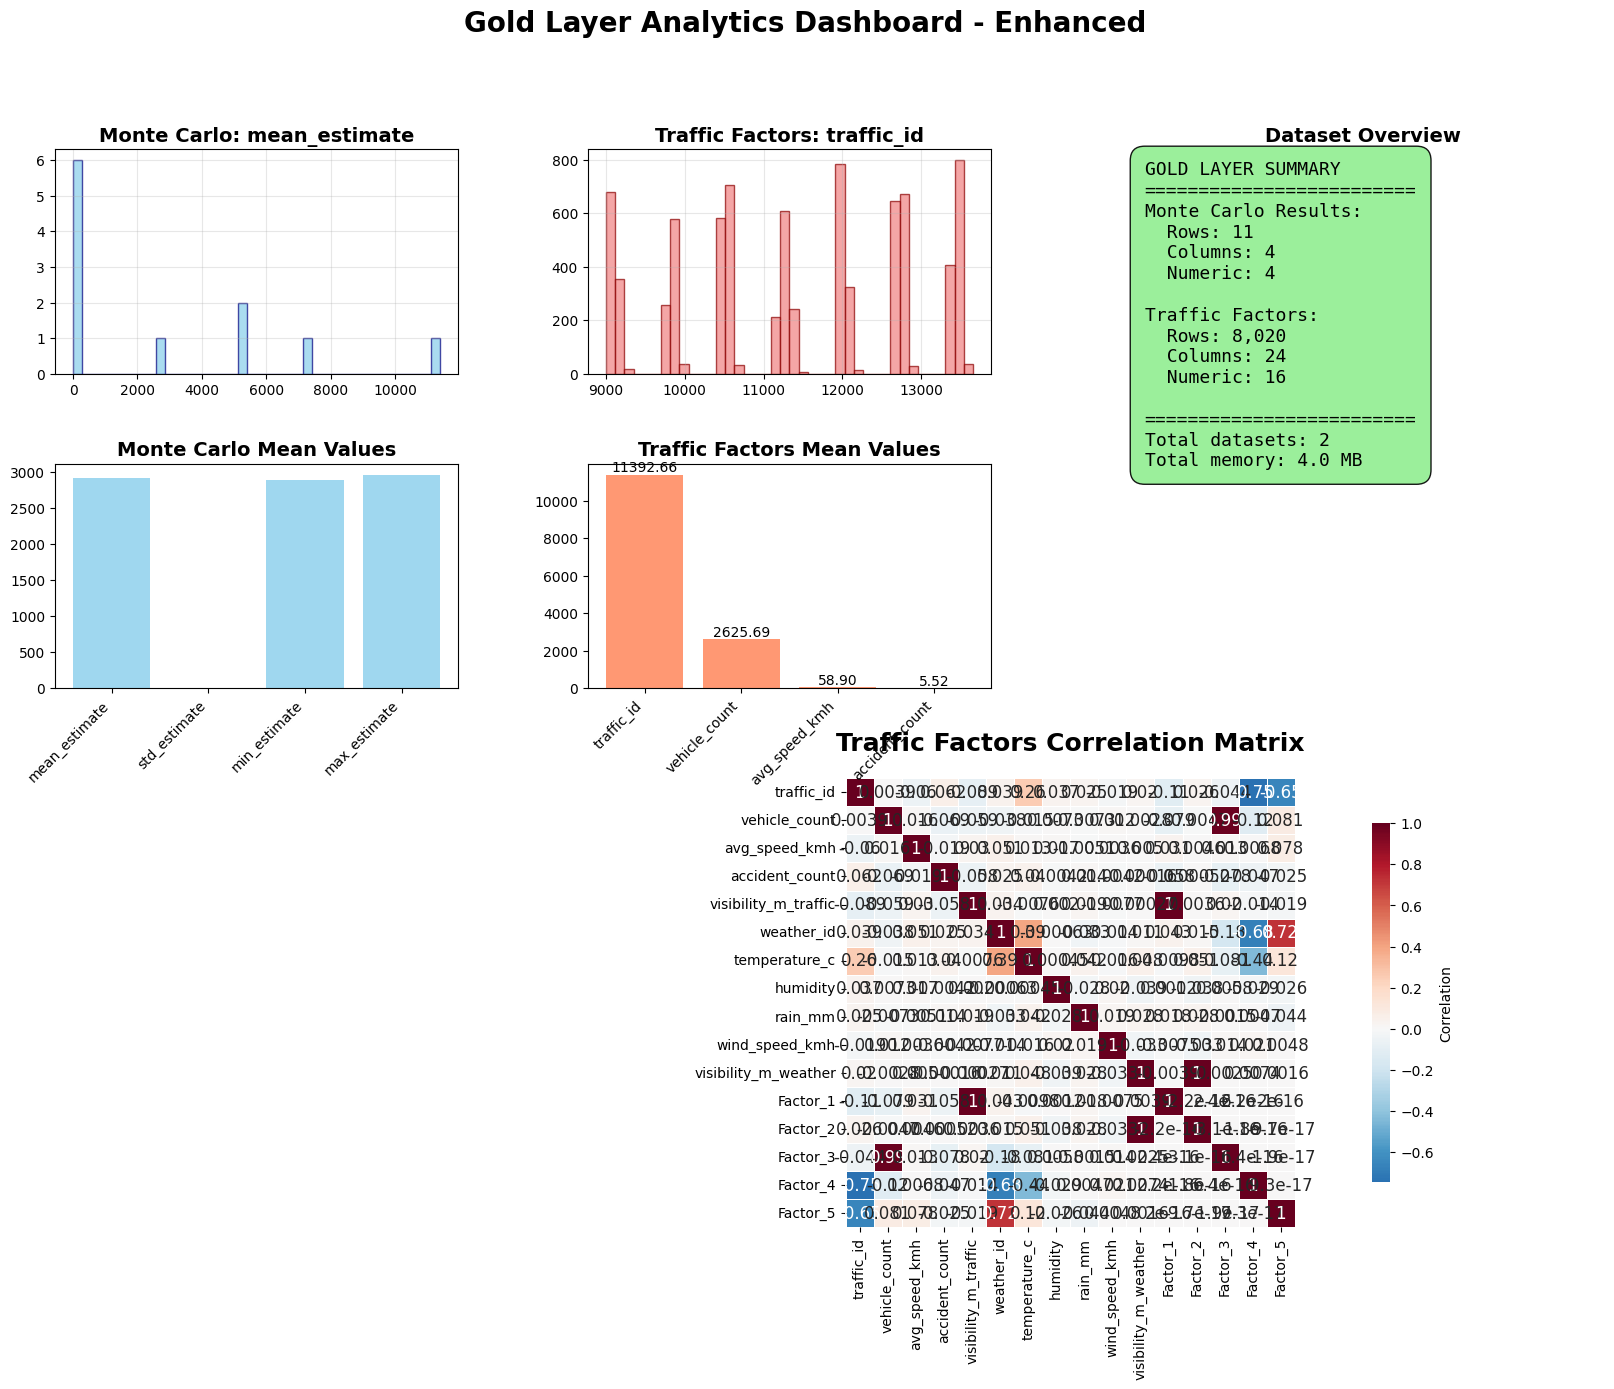

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Fixed enhanced dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 2], width_ratios=[1, 1, 1.2], hspace=0.3, wspace=0.3)

fig.suptitle('Gold Layer Analytics Dashboard - Enhanced', fontsize=20, fontweight='bold')

# 1. Monte Carlo visualization
ax1 = fig.add_subplot(gs[0, 0])
mc_numeric_cols = monte_carlo_df.select_dtypes(include=['number']).columns
if len(mc_numeric_cols) > 0:
    mc_col = mc_numeric_cols[0]
    monte_carlo_df[mc_col].hist(ax=ax1, bins=40, alpha=0.7, color='skyblue', edgecolor='navy')
    ax1.set_title(f'Monte Carlo: {mc_col}', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Monte Carlo Results', fontsize=14, fontweight='bold')

# 2. Traffic factors visualization
ax2 = fig.add_subplot(gs[0, 1])
tf_numeric_cols = traffic_factors_df.select_dtypes(include=['number']).columns
if len(tf_numeric_cols) > 0:
    tf_col = tf_numeric_cols[0]
    traffic_factors_df[tf_col].hist(ax=ax2, bins=40, alpha=0.7, color='lightcoral', edgecolor='darkred')
    ax2.set_title(f'Traffic Factors: {tf_col}', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Traffic Factors', fontsize=14, fontweight='bold')
# 3. LARGE CORRELATION MATRIX
ax3 = fig.add_subplot(gs[2, :])
if len(tf_numeric_cols) >= 2:
    corr_matrix = traffic_factors_df[tf_numeric_cols].corr()
    sns.heatmap(
        corr_matrix, 
        annot=True,
        annot_kws={'size': 12},
        cmap='RdBu_r',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
        ax=ax3
    )
    ax3.set_title('Traffic Factors Correlation Matrix', fontsize=18, fontweight='bold', pad=20)
else:
    ax3.text(0.5, 0.5, 'Insufficient\nnumeric columns', ha='center', va='center', transform=ax3.transAxes, fontsize=16)
    ax3.set_title('Correlation Matrix', fontsize=18, fontweight='bold')


# 4. Dataset summary
ax4 = fig.add_subplot(gs[0, 2])
mc_count = len(monte_carlo_df.select_dtypes(include=['number']).columns)
tf_count = len(traffic_factors_df.select_dtypes(include=['number']).columns)

summary_text = f"""GOLD LAYER SUMMARY
{'='*25}
Monte Carlo Results:
  Rows: {monte_carlo_df.shape[0]:,}
  Columns: {monte_carlo_df.shape[1]}
  Numeric: {mc_count}

Traffic Factors:
  Rows: {traffic_factors_df.shape[0]:,}
  Columns: {traffic_factors_df.shape[1]}
  Numeric: {tf_count}

{'='*25}
Total datasets: {len(gold_dataframes)}
Total memory: {(monte_carlo_df.memory_usage(deep=True).sum() + 
                traffic_factors_df.memory_usage(deep=True).sum()) / 1024**2:.1f} MB"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=13,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', alpha=0.9))
ax4.set_title('Dataset Overview', fontsize=14, fontweight='bold')
ax4.axis('off')

# 5. Monte Carlo statistics
ax5 = fig.add_subplot(gs[1, 0])
if len(mc_numeric_cols) > 0:
    mc_stats = monte_carlo_df[mc_numeric_cols[:4]].describe().iloc[1]  # mean row
    bars = ax5.bar(range(len(mc_stats)), mc_stats.values, color='skyblue', alpha=0.8)
    ax5.set_title('Monte Carlo Mean Values', fontsize=14, fontweight='bold')
    ax5.set_xticks(range(len(mc_stats)))
    ax5.set_xticklabels(mc_stats.index, rotation=45, ha='right')
else:
    ax5.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', fontsize=12)
    ax5.set_title('Monte Carlo Stats', fontsize=14)

# 6. FIXED Traffic factors statistics
ax6 = fig.add_subplot(gs[1, 1])
if len(tf_numeric_cols) > 0:
    # Fixed: Take first 4 numeric columns as list
    tf_cols_subset = tf_numeric_cols[:4].tolist()
    tf_stats = traffic_factors_df[tf_cols_subset].describe().iloc[1]  # mean row
    bars = ax6.bar(range(len(tf_stats)), tf_stats.values, color='coral', alpha=0.8)
    ax6.set_title('Traffic Factors Mean Values', fontsize=14, fontweight='bold')
    ax6.set_xticks(range(len(tf_stats)))
    ax6.set_xticklabels(tf_stats.index, rotation=45, ha='right')
    # Add value labels on bars
    for bar, val in zip(bars, tf_stats.values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=10)
else:
    ax6.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', fontsize=12)
    ax6.set_title('Traffic Factors Stats', fontsize=14)

plt.tight_layout()
plt.show()